In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from glob import glob
#from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Num GPUs Available:  1


/usr/local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
from pycocotools.coco import COCO
import skimage.io as io

In [3]:
DATA_DIR='../data/anshika/'
DATA_TYPE ='default'
ANNOTATION_FILE='{}/annotations/instances_{}.json'.format(DATA_DIR, DATA_TYPE, ragged = 'true')

FIG_DIR = "../data/anshika/trainval_images/"

In [4]:
# initialize COCO api for instance annotations
coco=COCO(ANNOTATION_FILE)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
PET Bottle Plastics Glassmetals Others Fishery bouy Driftwood firing Styrene



In [6]:
print(*cats, sep='\n')

{'id': 1, 'name': 'PET Bottle', 'supercategory': ''}
{'id': 2, 'name': 'Plastics', 'supercategory': ''}
{'id': 3, 'name': 'Glassmetals', 'supercategory': ''}
{'id': 4, 'name': 'Others', 'supercategory': ''}
{'id': 5, 'name': 'Fishery bouy', 'supercategory': ''}
{'id': 6, 'name': 'Driftwood', 'supercategory': ''}
{'id': 7, 'name': 'firing Styrene', 'supercategory': ''}


In [7]:
from tqdm import tqdm
from PIL import Image, ImageDraw

In [8]:
fix_w, fix_h = 640, 640

In [9]:
#coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
images = []
masks = []
for i, img_id in tqdm(enumerate(coco.getImgIds())):
    img = coco.loadImgs(img_id)[0]
    img_obj=io.imread('%s/images/%s' % (DATA_DIR, img['file_name']))
    pil_img = Image.fromarray(img_obj, mode='RGB')
    resized_img = np.array(pil_img.resize((fix_w, fix_h)))
    images.append(resized_img)
    
    # make gray scale make data
    w, h = img['width'], img['height']
    mask = np.zeros((h, w), dtype=np.uint8)
    for ann in coco.loadAnns(coco.getAnnIds(imgIds=img['id'])):
        mask[coco.annToMask(ann).astype(bool)] = 1
    pil_mask = Image.fromarray(mask, mode='L')
    resized_mask = np.array(pil_mask.resize((fix_w, fix_h)))
    
    masks.append(resized_mask.reshape((fix_h, fix_w, 1)))
    #masks.append(mask.reshape((h, w, 1)))

32it [00:47,  1.48s/it]


In [10]:
train_num = int(len(images)*0.8)
val_num = len(images) - train_num
train_num

25

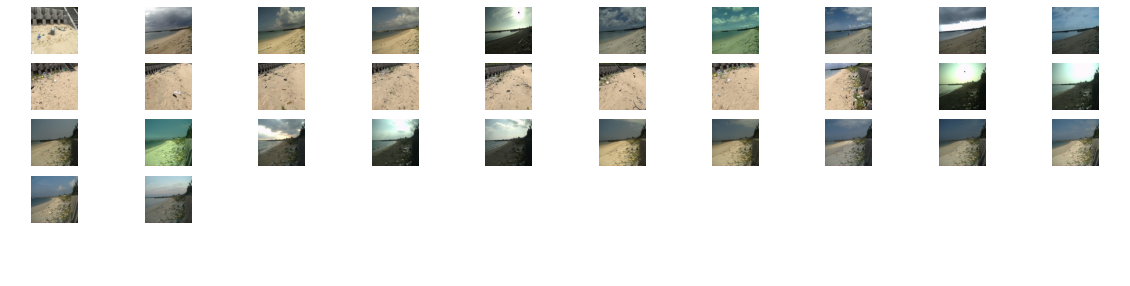

In [11]:
fig, axs = plt.subplots(5,10, figsize=(20,5))

for i, img in enumerate(images[:train_num+val_num]):
    axs[i//10, i%10].imshow(img)
for i in axs:
    for j in i:
        j.axis("off")

plt.savefig(FIG_DIR + 'train_image.png', format='PNG', dpi=300, bbox_inches='tight')
plt.show()

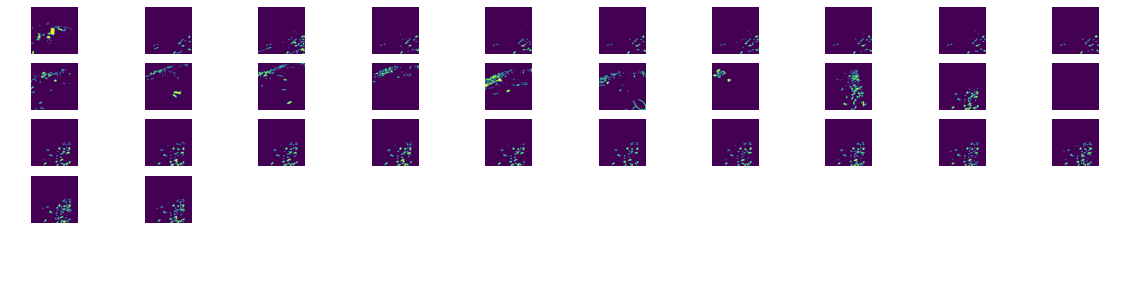

In [12]:
fig, axs = plt.subplots(5,10, figsize=(20,5))

for i, img in enumerate(masks[:train_num+val_num]):
    axs[i//10, i%10].imshow(img.reshape(img.shape[:2]))
for i in axs:
    for j in i:
        j.axis("off")

plt.savefig(FIG_DIR + 'train_mask.png', format='PNG', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
images[0].shape

(640, 640, 3)

small_images = []
small_masks = []
for image, mask in zip(images, masks):
    if image.shape != images[0].shape:
        small_images.append(image)
        small_masks.append(mask)
print(len(small_images))

In [18]:
dataset = {}
images = np.asarray(images)[:,0,0,0]
masks = np.asarray(masks)[:,0,0,0]
print(masks[:train_num].shape)

(25,)


In [19]:
#dataset = {}
dataset['train'] = tf.data.Dataset.from_tensor_slices({'image':images[:train_num], 'segmentation_mask': masks[:train_num]})

In [20]:
dataset['train']

<DatasetV1Adapter shapes: {image: (), segmentation_mask: ()}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>

In [21]:
dataset['val'] = tf.data.Dataset.from_tensor_slices({'image': images[train_num:train_num+val_num], 'segmentation_mask': masks[train_num:train_num+val_num]})
dataset['val']

<DatasetV1Adapter shapes: {image: (), segmentation_mask: ()}, types: {image: tf.uint8, segmentation_mask: tf.uint8}>

In [22]:
img_fnames = sorted(glob("../data/anshika/images/*.jpg"))
test_num = len(img_fnames)

In [23]:
_images = []
for i,fname in enumerate(img_fnames[:test_num]):
    _images.append(io.imread(fname))
#print(_images)

[array([[[186, 192, 180],
        [173, 179, 167],
        [154, 157, 146],
        ...,
        [ 19,  20,  12],
        [ 21,  20,  15],
        [ 22,  21,  17]],

       [[187, 193, 181],
        [174, 180, 168],
        [156, 159, 148],
        ...,
        [ 20,  21,  13],
        [ 25,  24,  19],
        [ 23,  22,  18]],

       [[193, 196, 185],
        [182, 185, 174],
        [164, 167, 156],
        ...,
        [ 19,  20,  12],
        [ 24,  23,  18],
        [ 24,  20,  17]],

       ...,

       [[194, 173, 142],
        [194, 173, 142],
        [191, 170, 139],
        ...,
        [219, 206, 172],
        [220, 207, 173],
        [218, 205, 171]],

       [[193, 172, 141],
        [195, 174, 143],
        [193, 172, 141],
        ...,
        [218, 205, 173],
        [219, 206, 172],
        [218, 205, 171]],

       [[189, 168, 137],
        [194, 173, 142],
        [195, 174, 143],
        ...,
        [218, 205, 173],
        [219, 206, 174],
        [218, 205, 171]

In [24]:
dataset['test'] = tf.data.Dataset.from_tensor_slices({'image': img_fnames[:test_num]})
dataset['test']

<DatasetV1Adapter shapes: {image: ()}, types: {image: tf.string}>

In [25]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [26]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
#     input_mask -= 1
    return input_image, input_mask

In [27]:
#image_size = len(small_images)
#print(image_size)

In [28]:
@tf.function
def load_image_train(datapoint):
    print(datapoint)
    input_image = tf.image.resize(datapoint['image'], (224,224,3))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (224,224))
    print(input_image)
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [29]:
def load_image_val(datapoint):
    input_image = tf.image.resize(datapoint['image'], (224,224,3))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (224,224))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [30]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (224,224,3))

    # normalize
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image

In [31]:
TRAIN_LENGTH = train_num
BATCH_SIZE = 2
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [32]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val = dataset['val'].map(load_image_val)
test = dataset['test'].map(load_image_test)

{'image': <tf.Tensor 'datapoint:0' shape=() dtype=uint8>, 'segmentation_mask': <tf.Tensor 'datapoint_1:0' shape=() dtype=uint8>}


ValueError: in converted code:

    <ipython-input-28-be64898eec18>:4 load_image_train
        input_image = tf.image.resize(datapoint['image'], (224,224,3))
    /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/image_ops_impl.py:1182 resize_images
        skip_resize_if_same=True)
    /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/image_ops_impl.py:1036 _resize_images_common
        raise ValueError('\'images\' must have either 3 or 4 dimensions.')

    ValueError: 'images' must have either 3 or 4 dimensions.


In [33]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val.batch(BATCH_SIZE)
test_dataset = test.batch(20)

NameError: name 'train' is not defined

In [34]:
non_data = 0
i = 0
for image, mask in val.take(3):
    sample_image, sample_mask = image, mask
    i += 1
    non_data += 1 if np.unique(sample_mask).shape[0] == 1 else 0
    display([sample_image, sample_mask])

NameError: name 'val' is not defined

In [ ]:
# クラス数
OUTPUT_CHANNELS = 3

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape= [256,256, 3], include_top=False, pooling = None)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x1664
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape= [256,256, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
import tensorflow_addons as tfa

In [ ]:
unet_model(OUTPUT_CHANNELS)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
print(model.summary())

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [ ]:
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

In [ ]:
InteractiveSession.close(sess)

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
%%time
EPOCHS = 20
VAL_SUBSPLITS = 3
VALIDATION_STEPS = train_num//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(val_dataset, 3)

In [ ]:
from PIL import Image

In [ ]:
%%time
# テストデータで予測結果を確認する
_, axs = plt.subplots(10,10, figsize=(20,20))
for _axs, image in zip(axs, test_dataset.take(test_num)):
    for _ax, img, pred in zip(_axs, image, model.predict(image)):
        pred = tf.argmax(pred, axis=-1)[..., tf.newaxis].numpy()[...,0]
        mask = np.ones((224,224)) * 255
        mask -= pred * 224
        mask = Image.fromarray(mask.astype(np.uint8))
        pred = np.tile(pred.reshape(224,224,1), 3)
        pred[...,0] *= 255
        im = Image.composite(Image.fromarray((img.numpy() * 255 / np.max(img.numpy())).astype('uint8')),
                             Image.fromarray(pred.astype(np.uint8)),
                             mask)
        _ax.imshow(np.array(im))

for i in axs:
    for j in i:
        j.axis("off")

# plt.savefig(FIG_DIR + 'test_image_flip.png', format='PNG', dpi=300, bbox_inches='tight')
plt.savefig(FIG_DIR + 'test_masked.png', format='PNG', dpi=300, bbox_inches='tight')
plt.show()